In [1]:
import io
import numpy as np
import tensorflow as tf
import pandas as pd
from scipy.io import wavfile
from python_speech_features import mfcc
import matplotlib.pyplot as plt
!pip install umap-learn
import umap
import seaborn as sns
from tqdm import tqdm

import tensorflow_addons as tfa

In [2]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(
        256,
        input_shape=(32,13),
        return_sequences=True
    ),
    tf.keras.layers.LSTM(
        256
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        256, 
        activation=None
    ), 
    tf.keras.layers.Lambda(
        lambda x: tf.math.l2_normalize(x, axis=1)
    )
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32, 256)           276480    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
lambda (Lambda)              (None, 256)               0         
Total params: 867,584
Trainable params: 867,584
Non-trainable params: 0
_________________________________________________________________


In [3]:
!ls /data/UrbanSound8K/metadata

UrbanSound8K.csv


In [4]:
metadata_path = "/data/UrbanSound8K/metadata/UrbanSound8K.csv"

df = pd.read_csv(metadata_path)

In [5]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [6]:
filepath = "/data/UrbanSound8K/audio/fold{fold}/{filename}"

len(df.index)

8732

In [30]:
test_file = filepath.format(
    fold=5,
    filename="100032-3-0-0.wav"
)

fs, sample = wavfile.read(test_file)

Data = []
Labels = []
Lengths = []

exception_count = 0
idx = 0
for row in df.iterrows():
    row=row[1]
    filename = filepath.format(
        fold=row['fold'],
        filename=row['slice_file_name']
    )
    try:
        audio = AudioSegment.from_wav(filename)
        fs, sample = audio.frame_rate, \
            np.array(audio.get_array_of_samples(), dtype=float)
        data = mfcc(signal=sample, samplerate=fs, nfft=2048+512)
        Lengths.append(data.shape[0])
        Data.append(data)
        Labels.append(row['class'])
        idx += 1
    except Exception as e:
        print(f"Exception: {filename}")
        exception_count += 1

print(f"Number of Exceptions: {exception_count}")

Exception: /data/UrbanSound8K/audio/fold5/19007-4-0-0.wav
Exception: /data/UrbanSound8K/audio/fold8/36429-2-0-13.wav
Exception: /data/UrbanSound8K/audio/fold8/36429-2-0-14.wav
Exception: /data/UrbanSound8K/audio/fold8/36429-2-0-15.wav
Exception: /data/UrbanSound8K/audio/fold8/36429-2-0-18.wav
Exception: /data/UrbanSound8K/audio/fold8/36429-2-0-23.wav
Exception: /data/UrbanSound8K/audio/fold8/36429-2-0-6.wav
Exception: /data/UrbanSound8K/audio/fold8/36429-2-0-7.wav
Exception: /data/UrbanSound8K/audio/fold1/88466-7-0-0.wav
Number of Exceptions: 9


In [ ]:
Data_ = np.array(Data)

np.save("/home/jovyan/work/preprocessed_data.npy", Data_)
import json
#json.dump(Label, open("/home/jovyan/work/processed_labels.json", 'w'))

(array([ 185.,  240.,  245.,  207.,  713.,  139.,   83.,   72.,   41.,
        6798.]),
 array([  9. ,  88.2, 167.4, 246.6, 325.8, 405. , 484.2, 563.4, 642.6,
        721.8, 801. ]),
 <a list of 10 Patch objects>)

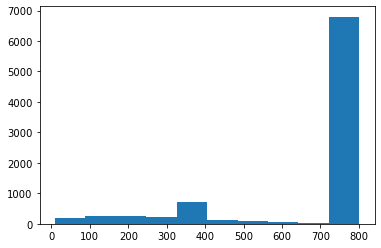

In [34]:
plt.hist(Lengths)

In [27]:
from pydub import AudioSegment

audio = AudioSegment.from_wav(filename)

audio.frame_rate

print(type(audio.get_array_of_samples()))

_data = mfcc(
    signal=np.array(audio.get_array_of_samples(),dtype=float), 
    samplerate=audio.frame_rate,
    nfft=2048+512
)

print(_data.shape)

<class 'array.array'>
(799, 13)


In [35]:
_Data = tf.keras.preprocessing.sequence.pad_sequences(
    Data,
    maxlen=1024,
    dtype='float32',
    padding='pre',
    truncating='pre',
    value=0.0
)

from random import randint

Map = {}
l = 0
Label = []

for label in Labels:
    if label not in Map:
        Map[label] = l
        l += 1
    Label.append(Map[label])

In [31]:
np.save("/home/jovyan/work/processed_data.npy", _Data)
import json
json.dump(Label, open("/home/jovyan/work/processed_labels.json", 'w'))

NameError: name '_Data' is not defined

In [33]:
_Data.shape

(5970, 32, 13)

In [34]:
X = zip(_Data, Label)

In [35]:
dataset = tf.data.Dataset.from_tensor_slices((_Data, Label))
dataset = dataset.shuffle(1024).batch(32)
dataset

<BatchDataset shapes: ((None, 32, 13), (None,)), types: (tf.float32, tf.int32)>

In [36]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())


In [42]:
# Train the network
history = model.fit(
    dataset,
    epochs=40
)

Epoch 1/40
187/187 [==============================] - 18s 97ms/step - loss: 0.4681
Epoch 2/40
187/187 [==============================] - 18s 97ms/step - loss: 0.4460
Epoch 3/40
187/187 [==============================] - 18s 96ms/step - loss: 0.4222
Epoch 4/40
187/187 [==============================] - 18s 96ms/step - loss: 0.3948
Epoch 5/40
187/187 [==============================] - 18s 98ms/step - loss: 0.3817
Epoch 6/40
187/187 [==============================] - 18s 99ms/step - loss: 0.3652
Epoch 7/40
187/187 [==============================] - 18s 95ms/step - loss: 0.3857
Epoch 8/40
187/187 [==============================] - 18s 95ms/step - loss: 0.3353
Epoch 9/40
187/187 [==============================] - 18s 97ms/step - loss: 0.3206
Epoch 10/40
187/187 [==============================] - 18s 96ms/step - loss: 0.3191
Epoch 11/40
187/187 [==============================] - 18s 96ms/step - loss: 0.3091
Epoch 12/40
187/187 [==============================] - 18s 96ms/step - loss: 0.3467
E

In [43]:
model.save("urban_sounds.tf")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: urban_sounds.tf/assets


INFO:tensorflow:Assets written to: urban_sounds.tf/assets


In [44]:
X = model.predict(_Data)

In [45]:
X.shape

(5970, 256)

In [46]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(X)
embedding.shape

/opt/conda/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


(5970, 2)

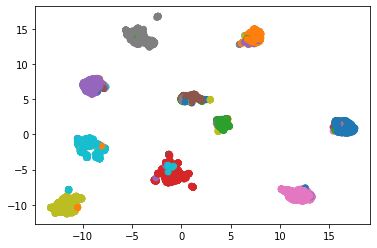

In [47]:
plt.scatter(embedding[:,0], embedding[:,1], c=[sns.color_palette()[x] for x in Label])